In [1]:
from scipy.fft import fft, ifft, fftshift, fft2, ifft2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

%matplotlib inline 

In [2]:
# We need a tool that converts images into grayscale (i.e. all pixel values in [0, 1])
def gray_scale_convert(image):
    rescaled_image = np.zeros((image.shape[0], image.shape[1]))
    rescaled_image[:, :] = image
    rescaled_image -= np.min(rescaled_image)
    rescaled_image /= np.max(rescaled_image)
    return rescaled_image

# Noisy Signals

Just to get a sense of the power of the FFT, we look at the signal 

$$
s(t) = \cos(2t) + \sin(3t) + \epsilon(t),  \epsilon(t) \sim \mathcal{N}(0, 1).
$$

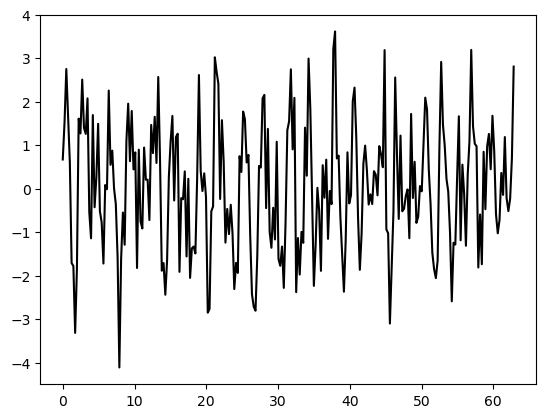

In [3]:
Npts = int(2**8)
times = np.linspace(0., 20.*np.pi, Npts)
rvals = np.random.randn(Npts)
sfun = lambda t: np.cos(2.*t) + np.sin(3.*t)
svals = sfun(times) + rvals

plt.plot(times, svals, 'k')
#plt.plot(times, sfun(times), 'r--')

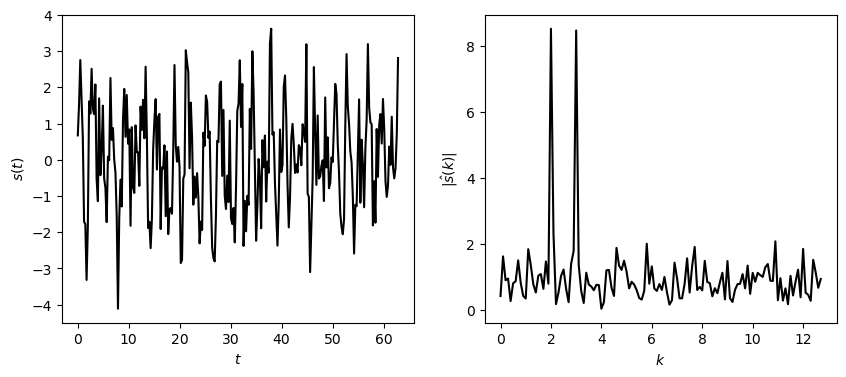

In [4]:
sfreq = fft(svals)
sfreq_plot = np.abs(fftshift(sfreq[:]))/np.sqrt(Npts)
kvals = np.arange(0, int(Npts/2)) * (2.*np.pi)/(20.*np.pi)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].plot(times, svals, 'k')
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$s(t)$")

ax[1].plot(kvals, sfreq_plot[int(Npts/2):], 'k')
ax[1].set_xlabel(r"$k$")
ax[1].set_ylabel(r"$|\hat{s}(k)|$");


So now, if we want to denoise, we use the same kind of threshholding to maximum arguments we used for the SVD.  This looks like:

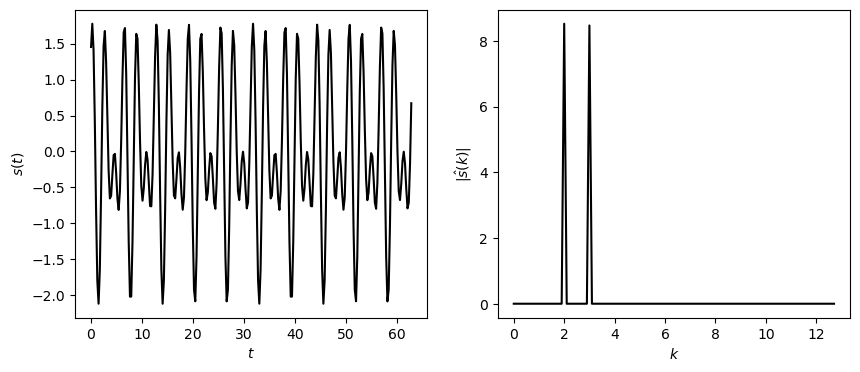

In [5]:
sfmax = np.max(np.abs(sfreq))
indskp = np.ma.log2(np.abs(sfreq)/sfmax) >= -1
sfilter = np.zeros(sfreq.size, dtype=np.complex128)
sfilter[indskp] = sfreq[indskp]
sfilter_plot = fftshift(np.abs(sfilter))/np.sqrt(Npts)
sdenoised = np.real(ifft(sfilter))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].plot(times, sdenoised, 'k')
#ax[0].plot(times, sfun(times), 'r--')
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$s(t)$")

ax[1].plot(kvals, sfilter_plot[int(Npts/2):], 'k')
ax[1].set_xlabel(r"$k$")
ax[1].set_ylabel(r"$|\hat{s}(k)|$");


# Image Analysis

Now, what happens when we use the 2D FFT on Beans?  

In [6]:
# Find, load, and convert image from textbook data
# Image is in Lecture_Notes folder 
dog_grayscale = io.imread('beans.jpg', as_gray=True)

dog_freq = fft2(dog_grayscale)
dog_freq_plot = np.log10(fftshift(np.abs(dog_freq)))

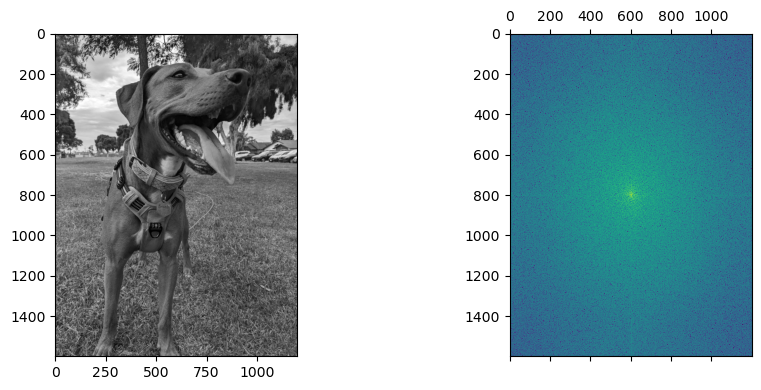

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()

ax[0].imshow(dog_grayscale, cmap=plt.cm.gray)
ax[1].matshow(dog_freq_plot)

plt.tight_layout()

So, there isn't really any clear interpretation of Beans in the FFT plot to the right.  Nevertheless, we can still do useful things with it.  To wit, we can look at, as you might have guessed, amplitude comparisons and only keep large Fourier coefficients.  

In [8]:
max_freq = np.max(np.abs(dog_freq))
indskp = np.ma.log10(np.abs(dog_freq)/max_freq) >= -3
dog_filter = np.zeros((dog_freq.shape[0], dog_freq.shape[1]), dtype=np.complex128)
dog_filter[indskp] = dog_freq[indskp]
dog_reduced = gray_scale_convert(np.real(ifft2(dog_filter)))

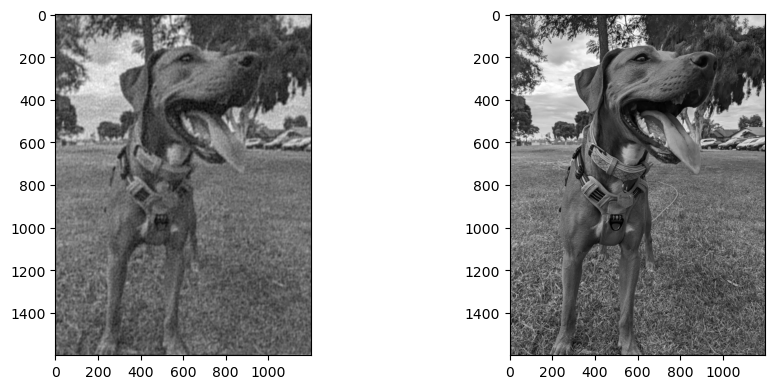

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()

ax[0].imshow(dog_reduced, cmap=plt.cm.gray)
ax[1].imshow(dog_grayscale, cmap=plt.cm.gray)

plt.tight_layout()

So with almost none of the affiliated Fourier spectra, we get a weirdly good recreation of Beans, but in a very different way than what we did with the SVD.  Let's see how the original and altered images look though through that lense.  

In [10]:
u, s, vh = np.linalg.svd(dog_grayscale)
ur, sr, vhr = np.linalg.svd(dog_reduced)

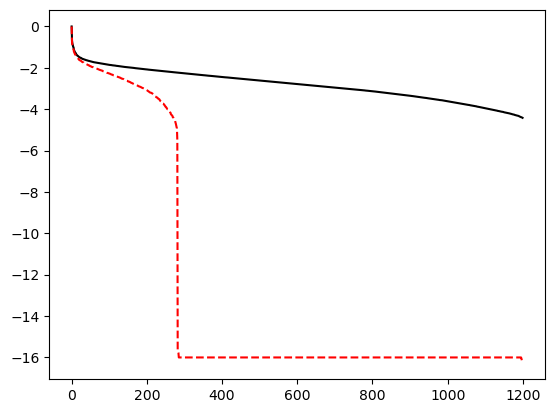

In [11]:
plt.plot(np.ma.log10(s/s[0]), color='k')
plt.plot(np.ma.log10(sr/sr[0]), color='r', ls='--')

So we see our FFT based approach is similar to chopping off dimensions in the SVD, though perhaps not quite as systematic in how we can describe the effect. 

## FFT Theory

For $f(t+T)=f(t)$ with $f(t) \in L_{2}([0, T])$, again, we define the Fourier coefficient $\hat{f}_{n}$ for $n\in \mathbb{Z}$ as 

$$
\hat{f}_{n} = \left<f,\hat{e}_{n}\right> = \frac{1}{\sqrt{T}}\int_{0}^{T}f(t) e^{-2\pi i n t/T} dt.  
$$

With a modicum of theory, we can in turn write

$$
f(t) = \sum_{n=-\infty}^{\infty}\hat{f}_{n}\hat{e}_{n}(t), \hat{e}_{n}(t) = \frac{1}{\sqrt{T}}e^{-2\pi i n t/T}.
$$

We can think of the transition from $f(t)$ to the infinte vector $\left(\hat{f}_{n}\right)_{n=-\infty}^{\infty}$ as the _forward_ transform, and the process of summing the terms $\hat{f}_{n}\hat{e}_{n}(t)$ as the _inverse_ transform.  